# Module 5 - Bayesian analysis

## Naive Bayes

Naive Bayes is a simple technique for constructing classifiers: models that assign class labels to problem instances, represented as vectors of feature values. There is not a single algorithm for training such classifiers, but a family of algorithms based on a common principle: all naive Bayes classifiers assume that the value of a particular feature is independent of the value of any other feature, given the class variable. For instance, if we want to describe an apple, features such as  color or shape would be considered independent from the fruit and with different probability distributions. In this workshop, we will explore two major algorithms for training a Naive Bayes classifier: the Gaussian Naive Bayes and the MultinomialNaive Baayes (there are others, of course).

Abstractly, naive Bayes is a conditional probability model: given a problem instance to be classified, represented by a vector $x =(x_{1},\dots ,x_{n})$, representing some *N* features or pieces of evidence (independent variables), it assigns to this instance probabilities

$Pr( C_k | x_1, x_2,..., x_N)$

for each of K possible outcomes or classes, $C_K$.

The problem with the above formulation is that if the number of features n is large or if a feature can take on a large number of values, then basing such a model on probability tables is infeasible. We therefore reformulate the model to make it more tractable. Using Bayes' theorem, the conditional probability can be decomposed as

$ Pr( C | x_1, x_2, ..., x_N ) = \frac{Pr(C) Pr(x_1, x_2, ..., x_N | C)}{Pr( x_1, x_2, ..., x_N)} $

In plain English, using Bayesian probability terminology, the above equation can be written as

$ posterior = \frac{ prior x likelihood }{evidence} $

## A General Machine Learning Architecture

A general supervised machine learning architecture consists in 2 major steps:
- **A Training Phase**
- **A Test Phase**

The **training phase** consists in getting a dataset with a set of features and pass it to a machine learning system (in this week, the machine learning system that you will learn is the Naive Bayes classifier). This machine learning system will output a mathematical function, which approximates the patterns and trends of the input training data. In machine learning, this function is usually referred to as a model. This model is computed through optimization problems that try to minimize the error between each datapoint during the training phase and its correct prediction. That is whay it is called *supervised* learning: one always needs to provide information about the true predictions of the data.

The **test phase** consists in the application of a set of data points that *were not used during the training phase* to the trained model, and evaluate how good that model is able to make a prediction.


<img src="graphics/ML.png" width="700px" />

## Task A: A Breast Cancer Classifier Using Naive Bayes

In this lecture, we will be applying Naive Bayes to try to predict if some tumor is malignant (cancer) or benign. 

### Import the Required Libraries

In [1]:
# Numerical Data Manipulation libraries
import pandas as pd
import numpy as np
import statistics as stat

# Figure Plotting libraries
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
sns.set()

# Naive Bayes libraries
import sklearn
from sklearn.naive_bayes import BernoulliNB      # Naive Bayes Classifier based on a Bernoulli Distribution
from sklearn.naive_bayes import GaussianNB       # Naive Bayes Classifier based on a Gaussian Distribution
from sklearn.naive_bayes import MultinomialNB    # Naive Bayes Classifier based on a Multinomial Distribution

# Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Text Analysis libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline

### Some Functions



In [2]:
# function to plot gaussian distribution in data
# you do not need to understand this in detail. Use it as a function that receives some data
# and plots a gaussian distribution over it
def func_plot_gaussian( data, ylim = (5, 42), xlim = (5, 30) ):

    # separate the benign tumours (diagnosis = 0) from the malignant ones (diagnosis = 1)
    mal = data[ data[ 'diagnosis'] == 1]
    ben = data[ data[ 'diagnosis'] == 0]

    # need to convert dataframe into a matrix in order to make the plot work
    X = data[ ['radius_mean', 'texture_mean'] ]
    x = X.to_numpy()

    # plot figure
    fig=plt.figure(dpi=150)
    ax= fig.add_subplot(111)
    
    # plot the datapoints of our data and color encodede them according to their diagnosis (malignant / benign)
    plt.scatter(mal['radius_mean'], mal['texture_mean'], c='r', marker='s', s=3, label='malignant')
    plt.scatter(ben['radius_mean'], ben['texture_mean'], c='b', marker='o', s=3, label='benign')
    plt.ylabel('texture_mean', fontsize=12)
    plt.xlabel('radius_mean', fontsize=12)
    plt.title('Breast Tumors', fontsize=14)
    plt.legend()

    # plot the gaussian curves over the data
    # a gaussian distribution can be computed by having the mean of the data, variable mu
    # and the standard deviation of the data, vatiable std
    xg = np.linspace(xlim[0], xlim[1], 60)
    yg = np.linspace(ylim[0], ylim[1], 40)
    xx, yy = np.meshgrid(xg, yg)
    Xgrid = np.vstack([xx.ravel(), yy.ravel()]).T

    for label, color in enumerate(['blue', 'red']):
        mask = (y == label)
        mu, std = x[mask].mean(0), x[mask].std(0)
        P = np.exp(-0.5 * (Xgrid - mu) ** 2 / std ** 2).prod(1) # Gaussian distr. mathematical formula
        Pm = np.ma.masked_array(P, P < 0.05)
        ax.pcolorfast(xg, yg, Pm.reshape(xx.shape), alpha=0.5, cmap=color.title() + 's')
        ax.contour(xx, yy, P.reshape(xx.shape), levels=[0.01, 0.1, 0.5, 0.9], colors=color, alpha=0.2) 
    
    ax.set(xlim=xlim, ylim=ylim)
    fig.show()
    return

### The Dataset

In [3]:
# Load breast cancer dataset
# Data describes if a tumour is MALIGNANT (value 1) or BENIGN (value 0) accordong to:
# - mean radius of the tumour
# - mean texture of the tumour
file_path = 'data/breast_data_simple.csv'
data = pd.read_csv( file_path )

In [4]:
data

,diagnosis,radius_mean,texture_mean
0,1,17.99,10.38
1,1,20.57,17.77
2,1,19.69,21.25
3,1,11.42,20.38
4,1,20.29,14.34
...,...,...,...
564,1,21.56,22.39
565,1,20.13,28.25
566,1,16.60,28.08
567,1,20.60,29.33


In [5]:
# 1st step towards a machine learning apporach: separate your dataset!
# put the variable that you wish to classify (or predict) in one variable
# put your sources of evidence (or your features) in another variable
y = data['diagnosis']                        # variable to classify and preduict
X = data[['radius_mean', 'texture_mean']]    # variable containing your features

Let's look at out variables:

In [6]:
y

0      1
1      1
2      1
3      1
4      1
      ..
564    1
565    1
566    1
567    1
568    0
Name: diagnosis, Length: 569, dtype: int64

In [7]:
X

,radius_mean,texture_mean
0,17.99,10.38
1,20.57,17.77
2,19.69,21.25
3,11.42,20.38
4,20.29,14.34
...,...,...
564,21.56,22.39
565,20.13,28.25
566,16.60,28.08
567,20.60,29.33


Before we proceed with any data analysis, we need to try to understand what kind of data are we dealing with. 
Naive Bayes model (like most machine learning models) are based on statistical learning. This means that the distribution of your data plays an important role in how successful the machine learning algorithm is.

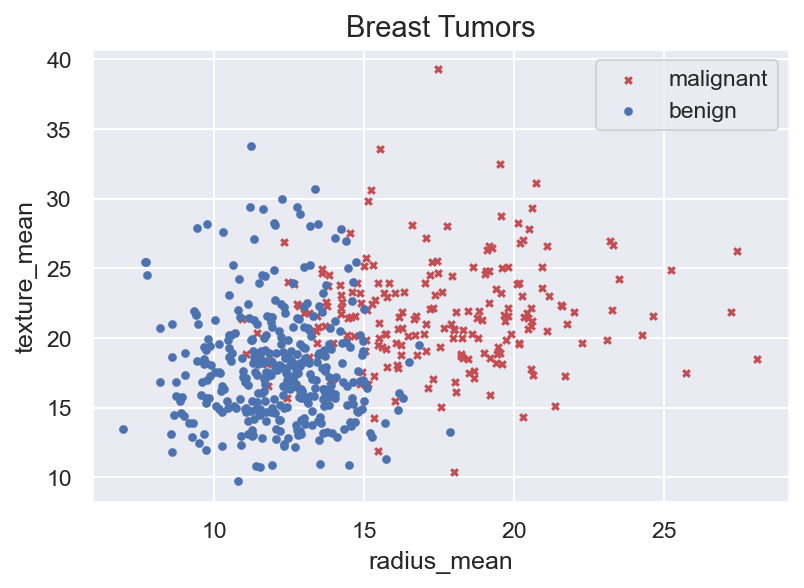

In [8]:
# for plotting purposes:
# separate the benign tumors (diagnosis = 0) from the malignant ones (diagnosis = 1)
malignant = data[ data[ 'diagnosis'] == 1]
benign = data[ data[ 'diagnosis'] == 0]

# need to convert dataframe into a matrix in order to make the plot work
x = X.to_numpy()

# plot figure
fig=plt.figure(dpi=150)

plt.scatter(malignant['radius_mean'], malignant['texture_mean'], c='r', marker='x', s=10, label='malignant', cmap='RdBu')
plt.scatter(benign['radius_mean'], benign['texture_mean'], c='b', marker='o', s=10, label='benign', cmap='RdBu')
plt.ylabel('texture_mean', fontsize=12)
plt.xlabel('radius_mean', fontsize=12)
plt.title('Breast Tumors', fontsize=14)
plt.legend()
plt.show()

Our dataset is not sparse, which is good (it is hard to model sparse data). The data sems to be concentric and distributed around a mean value. In statistics and machine learning, we usually represent data with a Gaussian Distribution (which is nothing more than a bell shaped curve). Let's see this in our data:

<ipython-input-2-a355e878f887>:43: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


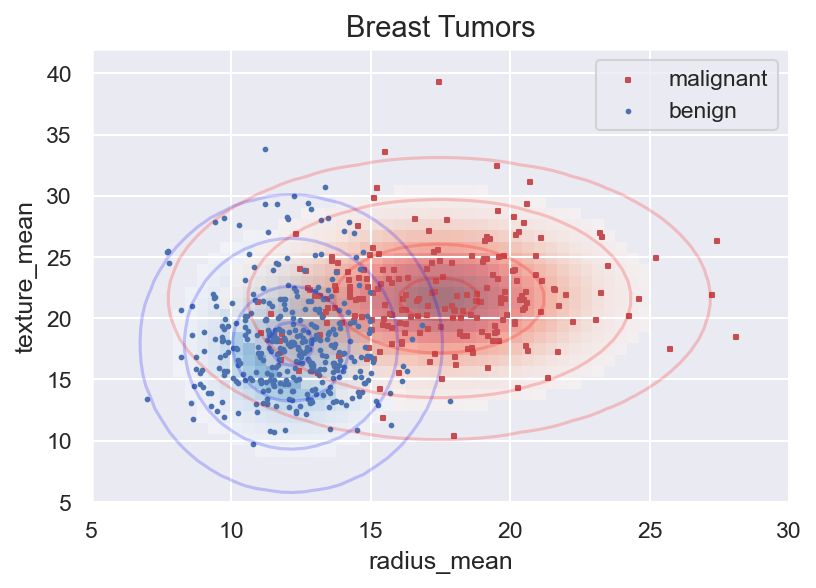

In [9]:
# plotting function defined in the begining of the notebook
func_plot_gaussian( data )

### Running the Naive Bayes Classifier with a Gaussian Kernel

Now that we took a look at our data and that we separated the data into a variable with the prediction, y, and another variable with the features, X, we need to split our data into two sets: a training set (used to estimate our model), and a test set (used to evaluate how good our model is).

**Remember!** Never use the same data on your training set as your test set! Why? If you ebaluate your model using that that was used to build that model, the the algorithm will always "know" what is the correct prediction of that data. That is why we always test a machine learning model with a set of data points that have never been seen by the model during the training phase!

#### The Importance of Defining Test and Training Sets

In [10]:
# create the training set and the test set
# good machine learning practices say that usually you should provide 70% of your data for training 
# and 30% of the data for testing
# test_size specifies how much data do you want to reserve for the test set
# the argument, random_state, is simply to ensure that we will have the same results
# when we run this cell many times. Since the split between the train set and the test set is random,
# by setting the random_state, we are ensuring reproducibility of the results.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 515)

In [11]:
# let's take a look at the size of our training sets and test sets
print( "Training set contains %d instances and the test set contains %d instances" %(X_train.shape[0], X_test.shape[0]))
print("Size of training set: %.2f" %((X_train.shape[0]/X.shape[0])*100))
print("Size of test set: %.2f" %((X_test.shape[0]/X.shape[0])*100))

Training set contains 398 instances and the test set contains 171 instances
Size of training set: 69.95
Size of test set: 30.05


#### Definition of the Type of Classifier

In [12]:
# learn the model

# STEP 2: specify the learning algorithm
# In this lecture, we will use a simple Gaussian Naive Bayes Model
model_base = GaussianNB()

# STEP 3: fit the training data to model
model_base.fit( X_train, y_train )

# STEP 4: make predictions on test set
# given a set of features that the system did not see before
# tries to predict the correct label to the data (label = malignant or benign tumor)
y_prediction = model_base.predict( X_test )

# # STEP 5: Measure the accuracy of the model
# compare the predicted results with the ones associated to X_test data
print( 'The overall accuracy of the model is %.2f%%' %(accuracy_score( y_test, y_prediction )*100))

The overall accuracy of the model is 84.21%


In the above code, we applied the 5 steps for a machine learning problem:
1. Split data into train and test sets
2. Specify the learning algorithm
3. Fit the training data to algorithm
4. Make predictions on test set
5. Measure the performance of the learnt model

#### Validating Results

In [13]:


trials = 500

accuracy = []
for trial in range( 0, trials ):
    
    # randomly select a test set and a training set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    y_expected = y_test
    
    GaussNB = GaussianNB()         # create the Gaussian Naive Bayes Classifer
    GaussNB.fit(X_train, y_train)  # fit the model to the training data

    y_predicted = GaussNB.predict(X_test)                       # get predictions of model on the test set
    accuracy.append(accuracy_score( y_expected, y_predicted ))  # save accuracy obtained in each trial
    print("Applying Naive Bayes............................ Trial #" + str(trial + 1) + " ....... acc = " + str( accuracy[trial] ))


Applying Naive Bayes............................ Trial #1 ....... acc = 0.9064327485380117
Applying Naive Bayes............................ Trial #2 ....... acc = 0.847953216374269
Applying Naive Bayes............................ Trial #3 ....... acc = 0.8421052631578947
Applying Naive Bayes............................ Trial #4 ....... acc = 0.8888888888888888
Applying Naive Bayes............................ Trial #5 ....... acc = 0.8713450292397661
Applying Naive Bayes............................ Trial #6 ....... acc = 0.8421052631578947
Applying Naive Bayes............................ Trial #7 ....... acc = 0.8771929824561403
Applying Naive Bayes............................ Trial #8 ....... acc = 0.8713450292397661
Applying Naive Bayes............................ Trial #9 ....... acc = 0.8771929824561403
Applying Naive Bayes............................ Trial #10 ....... acc = 0.8771929824561403
Applying Naive Bayes............................ Trial #11 ....... acc = 0.871345029239766

In [14]:
# Computute overall average accuracy over the 500 trials
min_accuracy = np.min(accuracy)
max_accuracy = np.max(accuracy)
avg_accuracy = np.mean( accuracy )

print("Results range from [%.2f, %.2f]" %(min_accuracy, max_accuracy))
print( "Average model accuracy is %.2f" %avg_accuracy  )

Results range from [0.82, 0.94]
Average model accuracy is 0.88


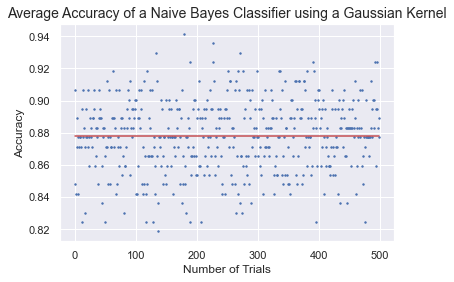

Average model accuracy is 0.88


In [15]:
# plot results
plt.figure()
plt.scatter( range( 0, trials ), accuracy, s = 2 )
lst = np.ones(trials, float)
plt.plot( range( 0, trials ), avg_accuracy*lst, c='r' )
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Number of Trials', fontsize=12)
plt.title('Average Accuracy of a Naive Bayes Classifier using a Gaussian Kernel', fontsize=14)
plt.show()

print( "Average model accuracy is %.2f" %avg_accuracy  )

#### What if we use another distribution? How about a Bernoulli distribution?

A Bernoulli distribution is the kind of distribution that you get when you flip a coin many times: you get a probability *p* of a coin landing heads, and you get a probability *(1-p)* of the coin landing tails. More formally, a Bernoulli distribution is the discrete probability distribution of a random variable which takes the value 1 with probability and the value 0 with probability.

In [18]:
trials = 500

accuracy = []
for trial in range( 0, trials ):
    
    # randomly select a test set and a training set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    y_expected = y_test
    
    # Specify the learning algorithm
    model = BernoulliNB()   
    
    # Fit the training data to algorithm
    model.fit(X_train, y_train)  # fit the model to the training data
    
    # Make predictions on test set using the learnt model
    y_predicted = model.predict(X_test)
    
    # Measure the performance of the learnt model
    accuracy.append(accuracy_score( y_expected, y_predicted ))  # save accuracy obtained in each trial
    
print( 'The average overall accuracy of the model is %.2f' %(accuracy_score( y_test, y_prediction )*100))

The average overall accuracy of the model is 54.39


What happen to the performance of our classifier? How can you justify this?